In [83]:
import os
from glob import glob
from tqdm import tqdm
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [84]:
comp_data_dir = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/'
train_record_ids = os.listdir(f"{comp_data_dir}/train/")
valid_record_ids = os.listdir(f"{comp_data_dir}/validation/")


In [47]:
num_labelers_list = []
for train_record_id in tqdm(train_record_ids):
    human_individual_masks = np.load(f"{comp_data_dir}/train/{train_record_id}/human_individual_masks.npy")
    num_labelers = human_individual_masks.shape[3]
    num_labelers_list.append(num_labelers)

labelers_unique_count = collections.Counter(num_labelers_list)
sorted(labelers_unique_count.items())

100%|██████████| 20529/20529 [02:36<00:00, 131.40it/s]


[(3, 1), (4, 18671), (5, 625), (6, 845), (7, 330), (8, 57)]

# ash-color/4labels

In [85]:
def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])


def get_false_color(record_data):
    _T11_BOUNDS = (243, 303)
    _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
    _TDIFF_BOUNDS = (-4, 2)

    r = normalize_range(record_data["band_15"] - record_data["band_14"], _TDIFF_BOUNDS)
    g = normalize_range(record_data["band_14"] - record_data["band_11"], _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(record_data["band_14"], _T11_BOUNDS)
    images = np.clip(np.stack([r, g, b], axis=2), 0, 1)

    return images


def read_record(record_id, comp_data_dir, mode):
    record_data = {}
    if mode in ["train"]:
        bands_mask = ["band_11", "band_14", "band_15", "human_individual_masks"]
    if mode in ["validation"]:
        bands_mask = ["band_11", "band_14", "band_15", "human_pixel_masks"]
    if mode in ["test"]:
        bands_mask = ["band_11", "band_14", "band_15"]

    for x in bands_mask:
        record_data[x] = np.load(os.path.join(comp_data_dir, record_id, x + ".npy"))
    return record_data


def process_individual_masks(human_individual_masks):
    num_masks = human_individual_masks.shape[-1]
    masks_sum = np.zeros(human_individual_masks[..., 0].shape)
    for i in range(num_masks):
        masks_sum += human_individual_masks[..., i]
    mask_agree = masks_sum/num_masks
    mask = []
    for p_agree in [0, 1/4, 2/4, 3/4]:
        mask.append(np.where(mask_agree > p_agree, 1, 0))
    mask = np.dstack(mask)
    return mask


def create_dataset(comp_data_dir, dataset_dir, image_dir, label_dir, mode):
    N_TIMES = 8
    N_TIMES_LABELED = 4
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    input_dir = f"{comp_data_dir}/{mode}"
    record_ids = os.listdir(input_dir)

    df = pd.DataFrame(record_ids, columns=['record_id'])
    df['image_path'] = image_dir + df['record_id'].astype(str) + f'_{N_TIMES_LABELED}.npy'
    df['label_path'] = label_dir + df['record_id'].astype(str) + f'_{N_TIMES_LABELED}.npy'
    df['time'] = N_TIMES_LABELED
    df.to_csv(f"{dataset_dir}/{mode}_df.csv", index=False)

    for record_id in tqdm(record_ids):
        record_data = read_record(str(record_id), input_dir, mode)

        images = get_false_color(record_data)
        image = images[..., N_TIMES_LABELED]
        image = image.astype(np.float16)
        npy_image_path = f"{image_dir}/{record_id}_{N_TIMES_LABELED}.npy"
        np.save(str(npy_image_path), image)

        if mode in ["train",]:
            label = process_individual_masks(record_data['human_individual_masks'])
        if mode in ["validation",]:
            label = record_data['human_pixel_masks']
        if mode in ["test"]:
            continue
        label = label.astype(np.float16)
        npy_label_path = f"{label_dir}/{record_id}_{N_TIMES_LABELED}.npy"
        np.save(str(npy_label_path), label)

In [86]:
dataset_train = "/kaggle/working/dataset_train/ash_color_4labels/"
dataset_train_images = f"{dataset_train}images/"
dataset_train_labels = f"{dataset_train}labels/true/"
dataset_test = "/kaggle/working/dataset_test/ash_color_4labels/images/"

# create_dataset(comp_data_dir, dataset_train, dataset_train_images, dataset_train_labels, "train")
create_dataset(comp_data_dir, dataset_train, dataset_train_images, dataset_train_labels, "validation")
# create_dataset(data_dir, dataset_test, "test")

100%|██████████| 1856/1856 [02:10<00:00, 14.27it/s]


In [48]:
for i, train_record_id in enumerate(tqdm(train_record_ids)):
    dataset_label = np.load(f"{dataset_train_labels}/{train_record_id}_4.npy")
    human_pixel_masks = np.load(f"{comp_data_dir}/train/{train_record_id}/human_pixel_masks.npy")

    is_match = np.all(dataset_label[:, :, 2] == human_pixel_masks[:, :, 0])

    if not is_match:
        print("not matched")
        break
print("checked")

100%|██████████| 20529/20529 [04:08<00:00, 82.66it/s] 

checked


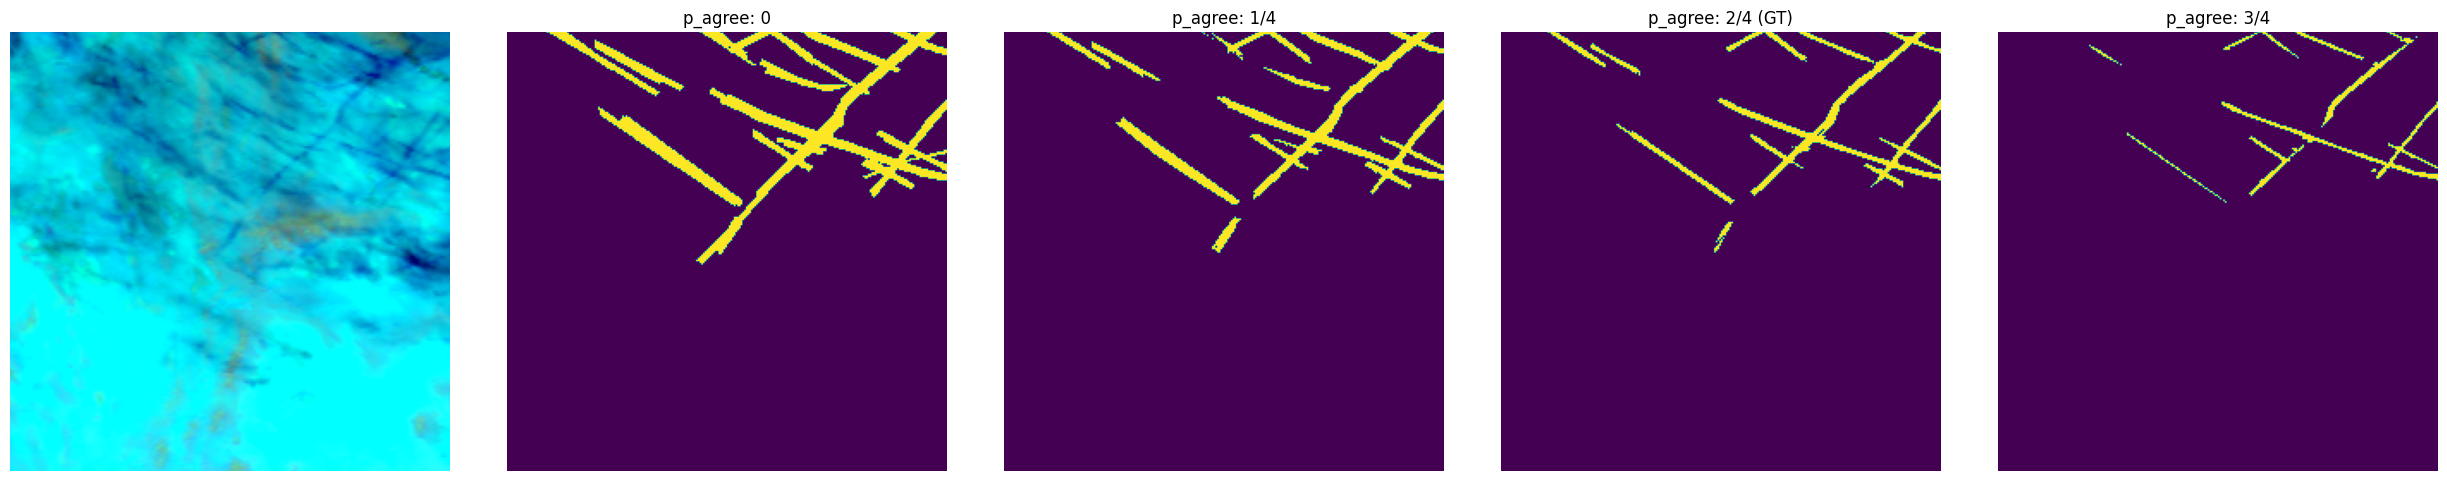

In [88]:
def plot_train_dataset(i):
    p_agree = ["0", "1/4", "2/4", "3/4"]
    train_record_id = train_record_ids[i]
    
    label = np.load(f"{dataset_train_labels}/{train_record_id}_4.npy")
    image = np.load(f"{dataset_train_images}/{train_record_id}_4.npy")
    
    fig, ax = plt.subplots(1, 5, figsize=(25, 20))
    fig.tight_layout()
    ax[0].imshow(image.astype(np.float32))
    ax[0].axis('off')
    for i in range(4):
        ax[i+1].imshow(label[..., i])
        ax[i+1].set_title(f"p_agree: {str(p_agree[i])}")
        if p_agree[i] == "2/4":
            ax[i+1].set_title(f"p_agree: {str(p_agree[i])} (GT)")
        ax[i+1].axis('off')
        

plot_train_dataset(50)